In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from dotenv import load_dotenv, find_dotenv
import os
from datetime import date, timedelta
import plotly.express as px

pd.set_option("display.max_columns", None)


In [2]:
# dotenv_path = find_dotenv()
# load_dotenv(dotenv_path)
# FACEIT_PLAYERID = os.environ.get("FACEIT_PLAYERID")
FACEIT_PLAYERID = "2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a"

In [3]:
DF_all = pd.read_pickle("./AllDatabz2.pkl", compression="bz2")


In [4]:
Map_names = ['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage','de_nuke', 'de_overpass', 'de_train']

In [5]:
DF_all = DF_all[DF_all['Map'].isin(Map_names)]
DF_all["K/D"] = DF_all["Kills"] / DF_all["Deaths"]
DF_all["K/A"] = DF_all["Kills"] / DF_all["Assists"]
DF_all = DF_all.query("Rounds > 16")
DF_all = DF_all[~DF_all["K/D"].isin([np.inf, -np.inf, np.nan])]
DF_all = DF_all[~DF_all["K/A"].isin([np.inf, -np.inf, np.nan])]



In [6]:
def count_wins(x):
    wins = x.value_counts().get("Win")
    if wins:
        return wins
    else:
        return 0

In [7]:
q_low = DF_all["Kills"].quantile(0.01)
q_hi = DF_all["Kills"].quantile(0.99)

DF_all = DF_all[(DF_all["Kills"] < q_hi) & (DF_all["Kills"] > q_low)]

In [8]:
DF_me = DF_all.query("PlayerId == @FACEIT_PLAYERID")
DF_others:pd.DataFrame = DF_all.query("PlayerId != @FACEIT_PLAYERID")

In [9]:
DF_me["index"] = np.arange(len(DF_me))

C:\Users\dima1\AppData\Local\Temp\ipykernel_40668\2280133688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_me["index"] = np.arange(len(DF_me))


In [10]:
Maps_others = (
    DF_others.groupby(by="Map")
    .aggregate(
        {
            "Kills": "sum",
            "Deaths": "sum",
            "Mvps": "sum",
            "Map": "count",
            "Headshots%": "mean",
            "Result": lambda x: count_wins(x), 
        }
    )
    .rename({"Map": "TimesPlayed"}, axis=1)
)

Maps_me = (
    DF_me.groupby(by="Map")
    .aggregate(
        {
            "Kills": "sum",
            "Deaths": "sum",
            "Mvps": "sum",
            "Map": "count",
            "Headshots%": "mean",
            "Result": lambda x: count_wins(x), 
        }
    )
    .rename({"Map": "TimesPlayed"}, axis=1)
)


In [11]:
data = Maps_others.sort_values(by = "TimesPlayed")

fig = px.bar(data, y="TimesPlayed", x=data.index,
            text_auto = ".2s",
            title="Most played maps for other players from Faceit"
            )
fig.update_layout(xaxis_tickangle=-30)

fig.show()

In [12]:
data = Maps_me.sort_values(by = "TimesPlayed")

fig = px.bar(data, y="TimesPlayed", x=data.index,
            text_auto = ".2s",
            title="My most played maps"
            )
fig.update_layout(xaxis_tickangle=-30)

fig.show()

In [13]:
Maps_others["WinRate%"] = (Maps_others["Result"] / Maps_others["TimesPlayed"] * 100).astype(int)
Maps_others["K/D"] = round(Maps_others["Kills"] / Maps_others["Deaths"], 2)
Maps_others.sort_values(by="TimesPlayed", inplace=True, ascending=False)
Maps_others["WinRateDiff"] = Maps_others["WinRate%"] - 50 


Maps_me["WinRate%"] = (Maps_me["Result"] / Maps_me["TimesPlayed"] * 100).astype(int)
Maps_me["K/D"] = round(Maps_me["Kills"] / Maps_me["Deaths"], 2)
Maps_me.sort_values(by="TimesPlayed", inplace=True, ascending=False)
Maps_me["WinRateDiff"] = Maps_me["WinRate%"] - 50 



In [14]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

In [15]:
data = Maps_others.sort_values(by = "WinRate%")

fig = px.bar(data, y="WinRate%", x=data.index,
            text=data["TimesPlayed"].apply(human_format),
            # text_auto = ".2f",
            title="Maps by win rate - others"
            )
fig.update_layout(xaxis_tickangle=-30)

fig.show()

In [16]:
data = Maps_me.sort_values(by = "WinRate%")

fig = px.bar(data, y="WinRate%", x=data.index,
            text=data["TimesPlayed"].apply(human_format),
            # text_auto = ".2f",
            title="Maps by win rate - me",
            
            
            
            )
fig.update_layout(xaxis_tickangle=-30)

fig.show()

In [91]:
def heatmap(data, title=""):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(corr.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=45)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)

    matrix = pd.DataFrame(data.corr(method="pearson")).round(2)
    for i in range(len(matrix)):
        for j in range(len(matrix.iloc[0])):
            text = ax.text(j, i, matrix.iloc[i, j], ha="center", va="center", color="w")
    ax.set_title(title, pad=20)


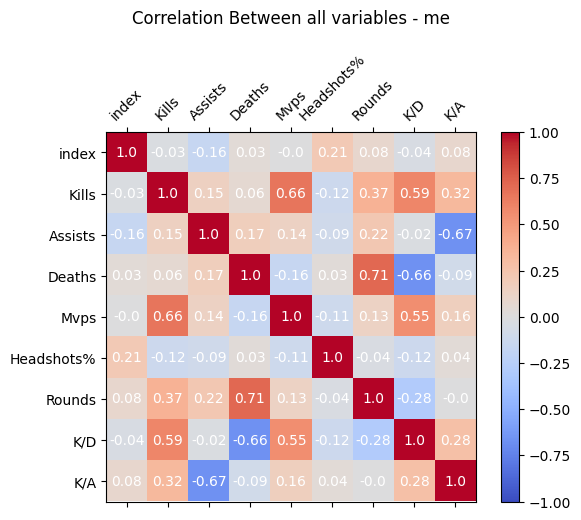

In [18]:
heatmap(
    DF_me.select_dtypes("number").drop(columns = ["Year", "Month", "Day", "DateOrdinal"]),
    title="Correlation Between all variables - me",
)

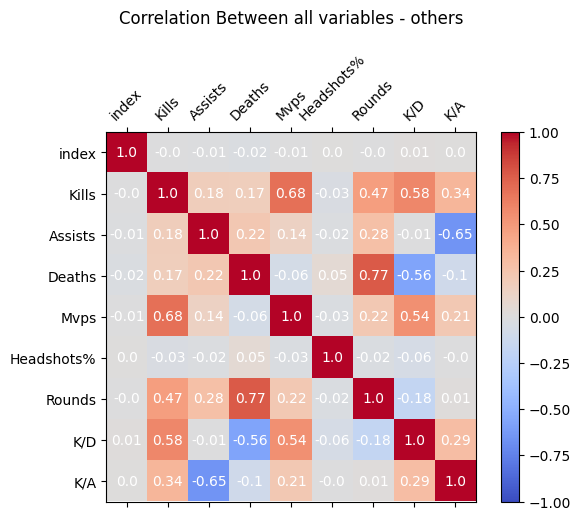

In [92]:
heatmap(
    DF_others.select_dtypes("number").drop(columns = ["Year", "Month", "Day", "DateOrdinal"]),
    title="Correlation Between all variables - others",
)


In [20]:
Maps_all = DF_all.groupby(by=["PlayerId", "Map"]).aggregate(
    {
        "Kills": "mean",
        "Assists": "mean",
        "Deaths": "mean",
        "Mvps": "mean",
        "Headshots%": "mean",
        "Map": "count",
        "Result": lambda x: count_wins(x),
    }
).rename({"Map": "TimesPlayed", "Result": "TimesWon"}, axis=1)#.reset_index()


In [21]:
Maps_all = Maps_all.query("TimesWon > 10")#.reset_index()

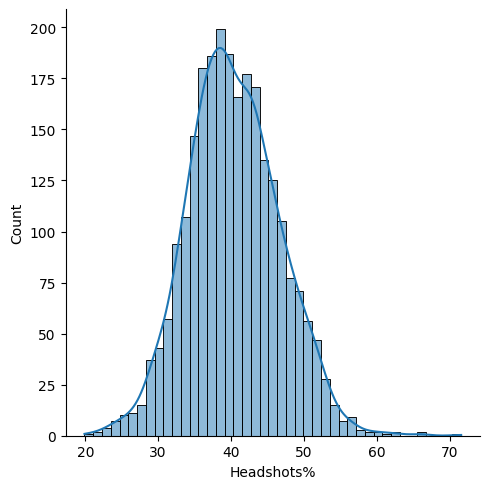

In [22]:
sns.displot(data = Maps_all, x = "Headshots%", kde = True)

In [23]:
Map_colours = dict(zip(Map_names, sns.color_palette("husl", 8)))

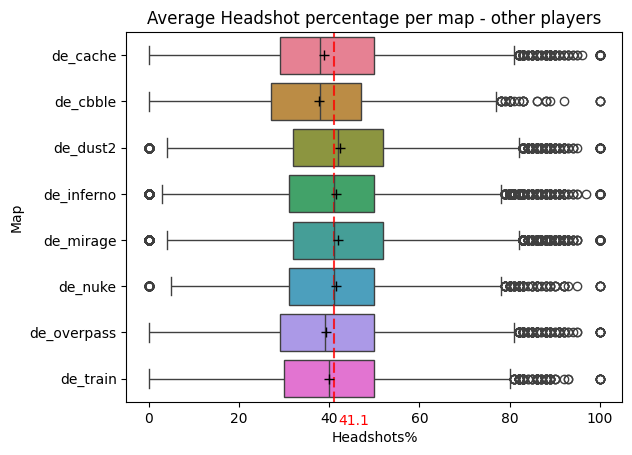

In [24]:
data = DF_all[DF_all["Headshots%"] <= 100]
avg = data["Headshots%"].mean()
g = sns.boxplot(
    data=data,
    x="Headshots%",
    y="Map",
    showmeans = True,
    order = Map_names,
    palette=Map_colours,
    meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "7"},
    hue="Map"
)
# for ax in g.axes.flat:
g.axvline(x=avg, color="red", alpha = .8, dashes=(5, 2))
plt.title("Average Headshot percentage per map - other players")
plt.text(avg+1, 8, round(avg, 1), color = "red", rotation = 0)
plt.show()

Text(0.5, 1.0, 'Average Headshot percentage per map - me')

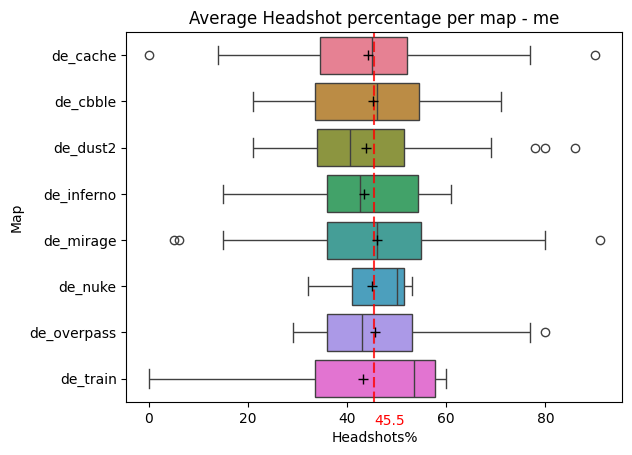

In [25]:
data = DF_me[DF_me["Headshots%"] <= 100]
avg = data["Headshots%"].mean()
g = sns.boxplot(
    data=data,
    x="Headshots%",
    y="Map",
    showmeans = True,
    order=Map_names,
    palette=Map_colours,
    meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "7"},
    hue= "Map"
)
# for ax in g.axes.flat:
g.axvline(x=avg, color="red", alpha = .8, dashes=(5, 2))
plt.text(avg, 8, round(avg, 1), color = "red", rotation = 0)

plt.title("Average Headshot percentage per map - me")

In [26]:
All_players = DF_all.groupby(by=["PlayerId"]).aggregate(
    {
        "Kills": "sum",
        "Assists": "sum",
        "Deaths": "sum",
        "Mvps": "sum",
        "Headshots%": "mean",
        "Map": "count",
        "Rounds": "sum",
        "Result": lambda x: count_wins(x),
    }
).rename({"Map": "TimesPlayed", "Result": "TimesWon"}, axis=1)#.reset_index()

All_players["K/D"] = All_players["Kills"] / All_players["Deaths"]
All_players["K/A"] = All_players["Kills"] / All_players["Assists"]

All_players["K/R"] = All_players["Kills"] / All_players["Rounds"]
All_players["A/R"] = All_players["Assists"] / All_players["Rounds"]
All_players["D/R"] = All_players["Deaths"] / All_players["Rounds"]

All_players["K/G"] = All_players["Kills"] / All_players["TimesPlayed"]
All_players["D/G"] = All_players["Deaths"] / All_players["TimesPlayed"]
All_players["A/G"] = All_players["Assists"] / All_players["TimesPlayed"]


In [27]:
# All_players = pd.concat([All_players, Me_overall])

In [28]:
All_players["Me"] = All_players.index == FACEIT_PLAYERID

In [29]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
#https://www.statology.org/matplotlib-abline/

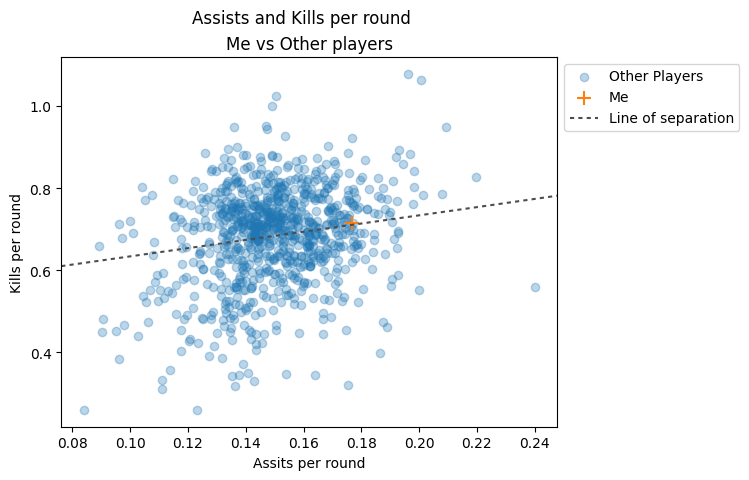

In [30]:
fig, ax = plt.subplots()
ax.scatter(All_players.query("Me != True")["A/R"], All_players.query("Me != True")["K/R"], alpha = 0.3, label = "Other Players")
ax.scatter(All_players.query("Me == True")["A/R"], All_players.query("Me == True")["K/R"], marker = "+", s = 100, label = "Me", alpha = 1)
ax.axline((All_players["A/R"].mean(), All_players["K/R"].mean()), slope = 1, color=".3", dashes=(2, 2), label = "Line of separation")
plt.xlabel("Assits per round")
plt.ylabel("Kills per round")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.suptitle("Assists and Kills per round")
plt.title("Me vs Other players")
plt.show()


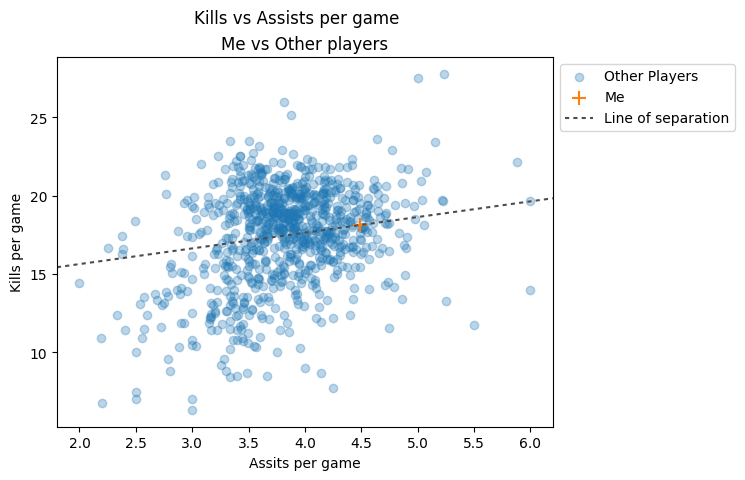

In [31]:
fig, ax = plt.subplots()
ax.scatter(All_players.query("Me != True")["A/G"], All_players.query("Me != True")["K/G"], alpha = 0.3, label = "Other Players")
ax.scatter(All_players.query("Me == True")["A/G"], All_players.query("Me == True")["K/G"], marker = "+", s = 100, label = "Me", alpha = 1)
ax.axline((All_players["A/G"].mean(), All_players["K/G"].mean()), slope = 1, color=".3", dashes=(2, 2), label = "Line of separation")
plt.xlabel("Assits per game")
plt.ylabel("Kills per game")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.suptitle("Kills vs Assists per game")
plt.title("Me vs Other players")
plt.show()


In [75]:
def linear_regression(x, y):
    meanx = np.mean(x)
    meany = np.mean(y)
    sigmax  = np.std(x)
    sigmay  = np.std(y)
    sigmaxy = np.sum(np.multiply(x-meanx,y-meany))/(len(x)-1)
    m = sigmaxy/(sigmax*sigmax)
    q = meany-m*meanx
    return m,q

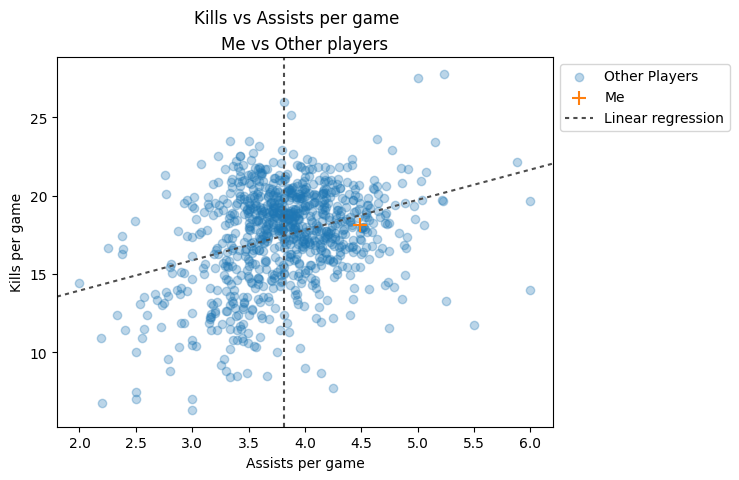

In [82]:
fig, ax = plt.subplots()


m, q = linear_regression(
    All_players.query("Me != True")["A/G"], All_players.query("Me != True")["K/G"]
)
line = m * All_players.query("Me != True")["A/G"] + q


ax.scatter(
    All_players.query("Me != True")["A/G"],
    All_players.query("Me != True")["K/G"],
    alpha=0.3,
    label="Other Players",
)
ax.scatter(
    All_players.query("Me == True")["A/G"],
    All_players.query("Me == True")["K/G"],
    marker="+",
    s=100,
    label="Me",
    alpha=1,
)


ax.axline(
    (All_players["A/G"].mean(), All_players["K/G"].mean()),
    slope=m,
    color=".3",
    dashes=(2, 2),
    label="Linear regression",
)

ax.axvline(
    All_players["A/G"].mean(),
    color=".3",
    dashes=(2, 2),
)

plt.xlabel("Assists per game")
plt.ylabel("Kills per game")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.suptitle("Kills vs Assists per game")
plt.title("Me vs Other players")
plt.show()


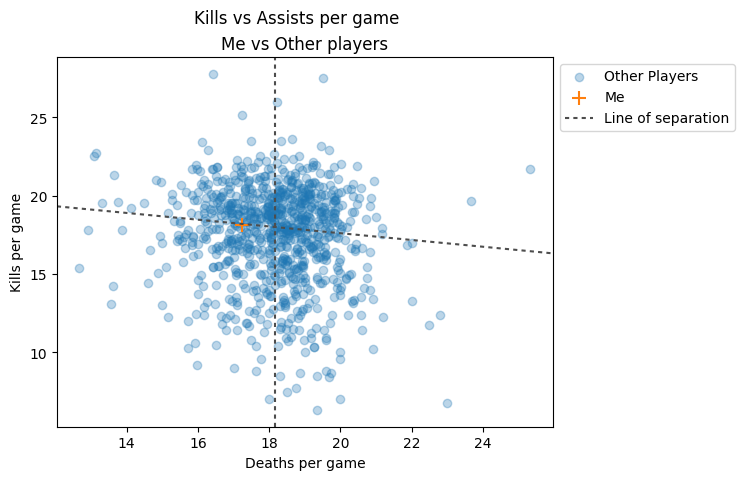

In [70]:
fig, ax = plt.subplots()
ax.scatter(
    All_players.query("Me != True")["D/G"],
    All_players.query("Me != True")["K/G"],
    alpha=0.3,
    label="Other Players",
)


m, q = linear_regression(All_players.query("Me != True")["D/G"], All_players.query("Me != True")["K/G"])
line = m * All_players.query("Me != True")["D/G"] + q

ax.scatter(
    All_players.query("Me == True")["D/G"],
    All_players.query("Me == True")["K/G"],
    marker="+",
    s=100,
    label="Me",
    alpha=1,
)


ax.axline(
    (All_players["K/G"].mean(),All_players["D/G"].mean()),
    slope = m,
    color=".3",
    dashes=(2, 2),
    label="Line of separation",
)

ax.axvline(
    All_players["D/G"].mean(),
    color=".3",
    dashes=(2, 2),
)

plt.xlabel("Deaths per game")
plt.ylabel("Kills per game")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.suptitle("Kills vs Assists per game")
plt.title("Me vs Other players")
plt.show()

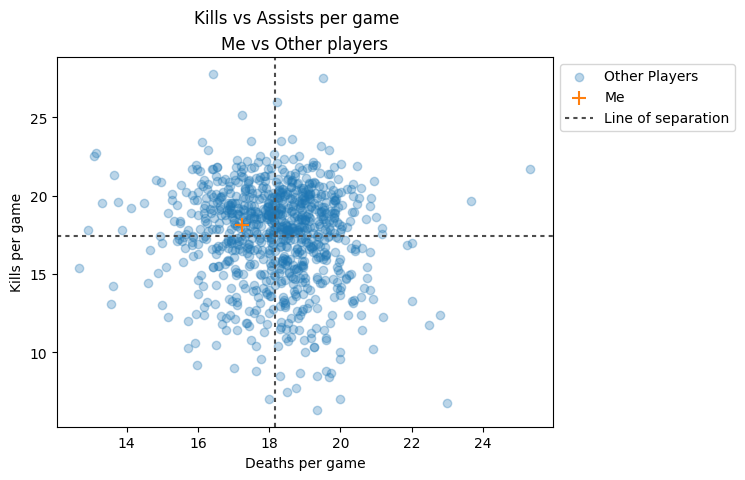

In [95]:
fig, ax = plt.subplots()
ax.scatter(
    All_players.query("Me != True")["D/G"],
    All_players.query("Me != True")["K/G"],
    alpha=0.3,
    label="Other Players",
)

ax.scatter(
    All_players.query("Me == True")["D/G"],
    All_players.query("Me == True")["K/G"],
    marker="+",
    s=100,
    label="Me",
    alpha=1,
)


ax.axhline(
    All_players["K/G"].mean(),
    color=".3",
    dashes=(2, 2),
    label="Line of separation",
)

ax.axvline(
    All_players["D/G"].mean(),
    color=".3",
    dashes=(2, 2),
)

plt.xlabel("Deaths per game")
plt.ylabel("Kills per game")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.suptitle("Kills vs Assists per game")
plt.title("Me vs Other players")
plt.show()

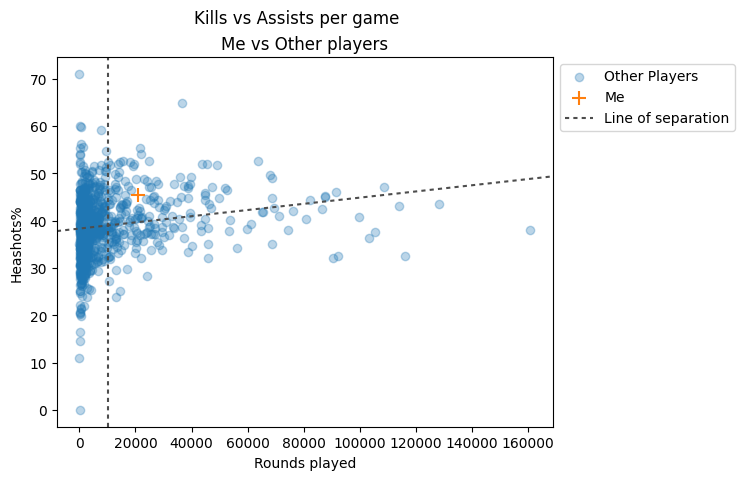

In [74]:
fig, ax = plt.subplots()
ax.scatter(
    All_players.query("Me != True")["Rounds"],
    All_players.query("Me != True")["Headshots%"],
    alpha=0.3,
    label="Other Players",
)

m, q = linear_regression(All_players.query("Me != True")["Rounds"], All_players.query("Me != True")["Headshots%"])
line = m * All_players.query("Me != True")["Rounds"] + q

ax.scatter(
    All_players.query("Me == True")["Rounds"],
    All_players.query("Me == True")["Headshots%"],
    marker="+",
    s=100,
    label="Me",
    alpha=1,
)


ax.axline(
    (All_players["Rounds"].mean(),All_players["Headshots%"].mean()),
    slope = m,
    color=".3",
    dashes=(2, 2),
    label="Line of separation",
)

ax.axvline(
    All_players["Rounds"].mean(),
    color=".3",
    dashes=(2, 2),
)

plt.xlabel("Rounds played")
plt.ylabel("Heashots%")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.suptitle("Kills vs Assists per game")
plt.title("Me vs Other players")
plt.show()

Text(21.150485436893202, 157, 'mean: 18')

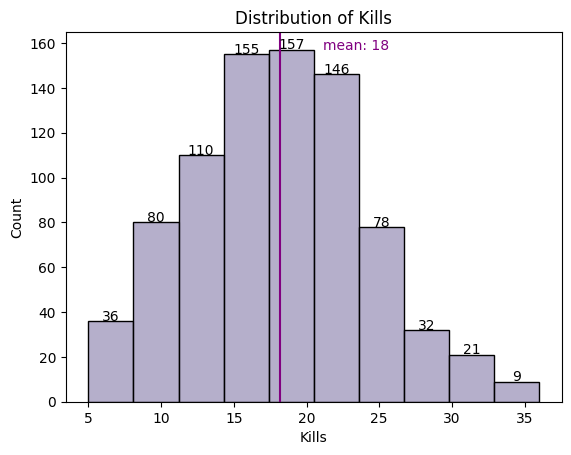

In [39]:
ax = sns.histplot(DF_me["Kills"], color="#9d94ba", bins=10, kde=False)
ax.set(title="Distribution of Kills")
# label each bar in histogram
for p in ax.patches:
    height = p.get_height()  # get the height of each bar
    # adding text to each bar
    ax.text(
        x=p.get_x()
        + (
            p.get_width() / 2
        ),  # x-coordinate position of data label, padded to be in the middle of the bar
        y=height + 0.2,  # y-coordinate position of data label, padded 0.2 above bar
        s="{:.0f}".format(height),  # data label, formatted to ignore decimals
        ha="center",
    )

plt.axvline(DF_me["Kills"].mean(), color="purple", label="mean")
# adding data label to mean line
plt.text(
    x=DF_me["Kills"].mean()
    + 3,  # x-coordinate position of data label, adjusted to be 3 right of the data point
    y=max(
        [h.get_height() for h in ax.patches]
    ),  # y-coordinate position of data label, to take max height
    s="mean: {:.0f}".format(DF_me["Kills"].mean()),  # data label
    color="purple",
)  # colour


# https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9


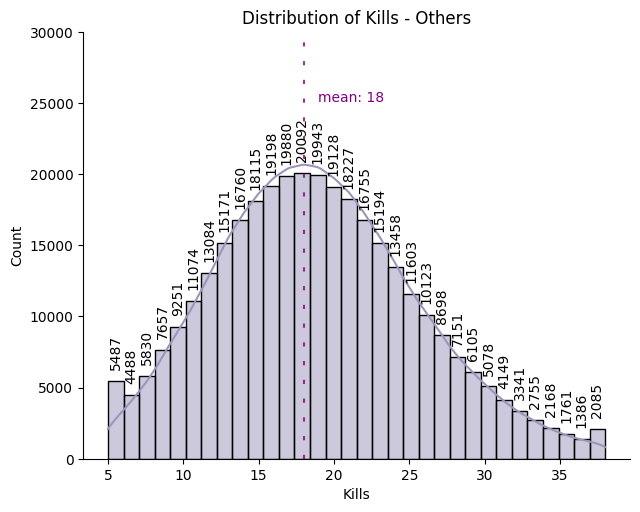

In [43]:
g = sns.displot(kind = "hist", x = DF_others["Kills"], color="#9d94ba", bins=32, kde=True, kde_kws = dict(bw_adjust=1.2), aspect=1.3)
for ax in g.axes.flat:

    ax.set(title="Distribution of Kills - Others")
    ax.set_ylim(0, 30000)
    # label each bar in histogram
    for p in ax.patches:
        height = p.get_height()  # get the height of each bar
        # adding text to each bar
        ax.text(
            x=p.get_x()
            + (
                p.get_width() / 2
            ),  # x-coordinate position of data label, padded to be in the middle of the bar
            y=height + 1000,  # y-coordinate position of data label, padded 0.2 above bar
            s="{:.0f}".format(height),  # data label, formatted to ignore decimals
            ha="center",
            rotation=90,
        )

    plt.axvline(
        int(DF_others["Kills"].mean()),
        color="purple",
        label="mean",
        alpha=0.8,
        dashes=(2, 7),
    )
    # adding data label to mean line
    plt.text(
        x=DF_others["Kills"].mean(),  # x-coordinate position of data label, adjusted to be 3 right of the data point
        y=max(
            [h.get_height() + 5000 for h in ax.patches]
        ),  # y-coordinate position of data label, to take max height
        s="mean: {:.0f}".format(int(DF_others["Kills"].mean())),  # data label
        color="purple",
    )  # colour


# https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9


Text(18.150485436893202, 71, 'mean: 18')

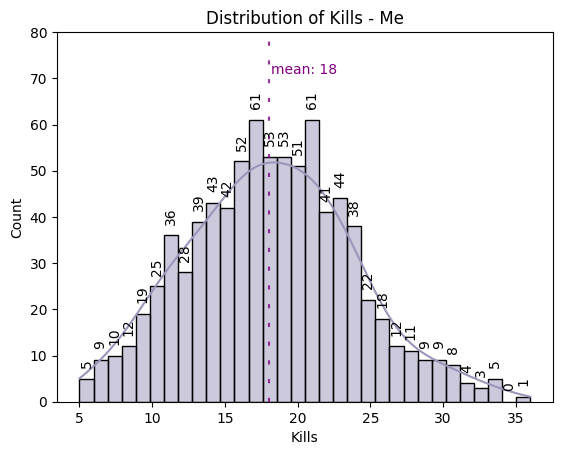

In [44]:
ax = sns.histplot(DF_me["Kills"], color="#9d94ba", bins = 32, kde=True, kde_kws = dict(bw_adjust=1.2))
ax.set(title="Distribution of Kills - Me")
ax.set_ylim(0, 80)
# label each bar in histogram
for p in ax.patches:
    height = p.get_height()  # get the height of each bar
    # adding text to each bar
    ax.text(
        x=p.get_x()
        + (
            p.get_width() / 2
        ),  # x-coordinate position of data label, padded to be in the middle of the bar
        y=height + 3,  # y-coordinate position of data label, padded 0.2 above bar
        s="{:.0f}".format(height),  # data label, formatted to ignore decimals
        ha="center",
        rotation=90,
    )

plt.axvline(
    int(DF_me["Kills"].mean()),
    color="purple",
    label="mean",
    alpha=0.8,
    dashes=(2, 7),
)
# adding data label to mean line
plt.text(
    x=DF_me["Kills"].mean(),  # x-coordinate position of data label, adjusted to be 3 right of the data point
    y=max(
        [h.get_height() + 10 for h in ax.patches]
    ),  # y-coordinate position of data label, to take max height
    s="mean: {:.0f}".format(int(DF_me["Kills"].mean())),  # data label
    color="purple",
)  # colour


# https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9
